# VDS for SASSIE ECCO using Virtualizarr v2.x

#### Status

* Able to merge multiple collections together into a 'super' VDS, but only for references that are in-memory. Still cannot open JSON's and save to disk. Should probably figure out how to save these as icechunks instead. 
* Lazy-loading the VDS's since moving to VZ v2.x continues to be slow.

In [41]:
# Built-in packages-----------------
import os
import sys
import shutil
import warnings
from typing import Optional

# Filesystem management-----------------
import earthaccess

import fsspec

from obstore.auth.earthdata import NasaEarthdataCredentialProvider
from obstore.store import S3Store
from obspec_utils.registry import ObjectStoreRegistry
import icechunk

# Data handling-----------------
import numpy as np
import xarray as xr
from virtualizarr import open_virtual_dataset
from virtualizarr.parsers import HDFParser
import pandas as pd

# Parallel computing -----------------
# import multiprocessing
# from dask import delayed
# import dask.array as da
# from dask.distributed import Client
# import coiled

# Other-----------------
import matplotlib.pyplot as plt

## 1. Setup

In [8]:
# Get Earthdata creds
auth = earthaccess.login()

In [9]:
credentials_url = "https://archive.podaac.earthdata.nasa.gov/s3credentials"
bucket = "s3://podaac-ops-cumulus-protected"

In [10]:
credential_provider = NasaEarthdataCredentialProvider(credentials_url, auth=(auth.username, auth.password))
store = S3Store.from_url(bucket, credential_provider=credential_provider)
registry = ObjectStoreRegistry({bucket: store})

In [11]:
shortnames = [
    "SASSIE_ECCO_L4_ATM_STATE_LLC1080GRID_DAILY_V1R1",
    "SASSIE_ECCO_L4_FRESH_FLUX_LLC1080GRID_DAILY_V1R1",
    "SASSIE_ECCO_L4_HEAT_FLUX_LLC1080GRID_DAILY_V1R1",
    "SASSIE_ECCO_L4_OBP_SSH_LLC1080GRID_DAILY_V1R1",
    "SASSIE_ECCO_L4_DENS_PRESS_LLC1080GRID_DAILY_V1R1",
    "SASSIE_ECCO_L4_OCN_3D_SALINITY_ADV_FLUX_LLC1080GRID_DAILY_V1R1",
    "SASSIE_ECCO_L4_OCN_3D_SALINITY_DIFF_FLUX_LLC1080GRID_DAILY_V1R1",
    "SASSIE_ECCO_L4_OCN_3D_TEMP_ADV_FLUX_LLC1080GRID_DAILY_V1R1",
    "SASSIE_ECCO_L4_OCN_3D_TEMP_DIFF_FLUX_LLC1080GRID_DAILY_V1R1",
    "SASSIE_ECCO_L4_OCN_3D_VOL_FLUX_LLC1080GRID_DAILY_V1R1",
    "SASSIE_ECCO_L4_OCN_VEL_LLC1080GRID_DAILY_V1R1",
    "SASSIE_ECCO_L4_SEA_ICE_CONC_THICK_VEL_LLC1080GRID_DAILY_V1R1",
    "SASSIE_ECCO_L4_SEA_ICE_VOL_AREA_TEND_LLC1080GRID_DAILY_V1R1",
    "SASSIE_ECCO_L4_SEA_ICE_VOL_AREA_FLUX_LLC1080GRID_DAILY_V1R1",
    "SASSIE_ECCO_L4_STRESS_LLC1080GRID_DAILY_V1R1",
    "SASSIE_ECCO_L4_TEMP_SALINITY_LLC1080GRID_DAILY_V1R1",
    "SASSIE_ECCO_L4_KPP_DIAGS_LLC1080GRID_DAILY_V1R1",
    "SASSIE_ECCO_L4_KPP_BOUNDARY_LAYER_LLC1080GRID_DAILY_V1R1",
    "SASSIE_ECCO_L4_OBP_SSH_LLC1080GRID_SNAPSHOT_V1R1",
    "SASSIE_ECCO_L4_SEA_ICE_CONC_THICK_VEL_LLC1080GRID_SNAPSHOT_V1R1",
    "SASSIE_ECCO_L4_TEMP_SALINITY_LLC1080GRID_SNAPSHOT_V1R1",
    "SASSIE_ECCO_L4_GEOMETRY_LLC1080GRID_V1R1"
]

## 2. Generate combined ref files for each collection

In [17]:
def open_vds_warnsupressed(datalink, **kwargs):
    """
    Just a wrapper around virtualizarr.open_virtual_dataset() but with a specific warning supressed.
    """
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message="Numcodecs codecs*", category=UserWarning)
        vds_ref = open_virtual_dataset(
                datalink, **kwargs
            )
    return vds_ref

ERROR! Session/line number was not unique in database. History logging moved to new session 2


In [36]:
def generate_combined_vds_ref(shortname, granule_info, registry):
    """
    """
    data_s3links = [g.data_links(access="direct")[0] for g in granule_info]
    
    ## Identify coord vars to pass to loadable_variables in virtualizarr -------------------
    grid_vars_reference = ['time', 'i', 'i_g', 'j', 'j_g', 'k', 'k_u', 'k_l', 'k_p1']
    data_sample = xr.open_dataset(earthaccess.open([granule_info[0]])[0])
    loadable_vars = []
    for c in list(data_sample.coords.keys()):
        if c in grid_vars_reference:
            loadable_vars.append(c)

    ## Create single file references ---------------------------------------------------------
    single_refs = []

    for s3l in data_s3links[:20]:
        vds_ref_single = open_vds_warnsupressed(
            s3l,
            parser=HDFParser(),
            registry=registry,
            loadable_variables=loadable_vars,
            decode_times=False
        )
        # vds_ref_single = open_virtual_dataset(
        #     s3l,
        #     parser=HDFParser(),
        #     registry=registry,
        #     loadable_variables=loadable_vars,
        #     decode_times=False
        # )
        single_refs.append(vds_ref_single)

    # Create the combined reference
    virtual_ref_combined = xr.combine_nested(
        single_refs, concat_dim=['time'], coords='minimal', 
        compat='override', combine_attrs='drop_conflicts'
    )

    return virtual_ref_combined

In [37]:
vds_refs_combined = []

for sn in shortnames[:10]:
    granule_info = earthaccess.search_data(
        short_name= sn,
    )
    vds_refs_combined.append(generate_combined_vds_ref(sn, granule_info, registry))

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

/opt/coiled/env/lib/python3.13/site-packages/zarr/codecs/numcodecs/_codecs.py:141: ZarrUserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

/opt/coiled/env/lib/python3.13/site-packages/zarr/codecs/numcodecs/_codecs.py:141: ZarrUserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

/opt/coiled/env/lib/python3.13/site-packages/zarr/codecs/numcodecs/_codecs.py:141: ZarrUserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

/opt/coiled/env/lib/python3.13/site-packages/zarr/codecs/numcodecs/_codecs.py:141: ZarrUserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

/opt/coiled/env/lib/python3.13/site-packages/zarr/codecs/numcodecs/_codecs.py:141: ZarrUserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

/opt/coiled/env/lib/python3.13/site-packages/zarr/codecs/numcodecs/_codecs.py:141: ZarrUserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

/opt/coiled/env/lib/python3.13/site-packages/zarr/codecs/numcodecs/_codecs.py:141: ZarrUserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

/opt/coiled/env/lib/python3.13/site-packages/zarr/codecs/numcodecs/_codecs.py:141: ZarrUserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

/opt/coiled/env/lib/python3.13/site-packages/zarr/codecs/numcodecs/_codecs.py:141: ZarrUserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

/opt/coiled/env/lib/python3.13/site-packages/zarr/codecs/numcodecs/_codecs.py:141: ZarrUserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)


## 3. Merge the combined reference files into a super VDS

## 3.1 Attempting to open VDS's from disk and combine

Currently opened refs with inlined vars is not allowed for JSON

In [21]:
from pathlib import Path
from virtualizarr.parsers import KerchunkJSONParser
from obstore.store import from_url

In [22]:
url_cwd = f"file://{str(Path.cwd())}"
store = from_url(url_cwd)
registry.register(url_cwd, store)

In [ ]:
vds = open_virtual_dataset('SASSIE_ECCO_L4_HEAT_FLUX_LLC1080GRID_DAILY_V1R1_virtual_s3.json', registry=registry, parser=KerchunkJSONParser())

## 3.2 Combining from VDS refs in memory

In [38]:
super_vds = xr.combine_nested(
    vds_refs_combined[:], concat_dim=None, 
    compat='override', combine_attrs='drop_conflicts'
)

In [39]:
super_vds.vz.to_kerchunk('SASSIE_ECCO_DAILY_ALL.json', format='json')

## 3.3 Create Icechunk store

In [42]:
def create_icechunk_repo_local(repo_name: str):
    """
    Creates an icechunk repository locally.

    Inputs
    ------
    * repo_name (str): path to icechunk repo.
    """
    storage = icechunk.local_filesystem_storage(path=repo_name)
    config = icechunk.RepositoryConfig.default()
    config.set_virtual_chunk_container(
        icechunk.VirtualChunkContainer(
            url_prefix=bucket+"/",
            store=icechunk.s3_store(region="us-west-2", anonymous=True)
        )
    )
    return icechunk.Repository.create(storage, config)

In [44]:
# Create icechunk repo and session
repo = create_icechunk_repo_local("SASSIE_ECCO_DAILY_ALL.icechunk")
session = repo.writable_session("main")

  2026-02-20T01:18:15.251967Z  WARN icechunk::storage::object_store: The LocalFileSystem storage is not safe for concurrent commits. If more than one thread/process will attempt to commit at the same time, prefer using object stores.
    at icechunk/src/storage/object_store.rs:81



In [45]:
# Then write the VDS to the store:
super_vds.virtualize.to_icechunk(session.store)
session.commit("Initial commit.")

'X0PXA4RH0H9996VV6V30'

In [46]:
repo.save_config()

## 4. Test combined reference file

## 4.1 Using fsspec

In [41]:
# Get AWS creds. Note that if you spend more than 1 hour in the notebook, you may have to re-run this line!!!
fs = earthaccess.get_s3_filesystem(daac="PODAAC")

In [42]:
def opends_withref_vz2(ref, fs_data):
    """
    "ref" is a reference file or object. "fs_data" is a filesystem with credentials to
    access the actual data files. 
    """
    storage_opts = {"fo": ref, "remote_protocol": "s3", "remote_options": fs_data.storage_options}
    fs_ref = fsspec.filesystem('reference', **storage_opts)
    m = fs_ref.get_mapper('')
    data = xr.open_dataset(
        m, engine="kerchunk", chunks={},
    )
    return data

In [43]:
%%time
data = opends_withref_vz2('SASSIE_ECCO_DAILY_ALL.json', fs)
data

CPU times: user 7.32 s, sys: 1.63 s, total: 8.95 s
Wall time: 1min 22s


<xarray.Dataset> Size: 3GB
Dimensions:    (time: 10, j: 1080, i: 1800, nb: 4, nv: 2)
Coordinates:
    XC         (j, i) float32 8MB dask.array<chunksize=(1080, 1800), meta=np.ndarray>
    XC_bnds    (j, i, nb) float32 31MB dask.array<chunksize=(1080, 1800, 4), meta=np.ndarray>
    YC         (j, i) float32 8MB dask.array<chunksize=(1080, 1800), meta=np.ndarray>
    YC_bnds    (j, i, nb) float32 31MB dask.array<chunksize=(1080, 1800, 4), meta=np.ndarray>
  * i          (i) int32 7kB 0 1 2 3 4 5 6 ... 1794 1795 1796 1797 1798 1799
  * j          (j) int32 4kB 0 1 2 3 4 5 6 ... 1074 1075 1076 1077 1078 1079
  * time       (time) datetime64[ns] 80B 2014-01-15T12:00:00 ... 2014-01-24T1...
    time_bnds  (time, nv) datetime64[ns] 160B dask.array<chunksize=(1, 2), meta=np.ndarray>
Dimensions without coordinates: nb, nv
Data variables: (12/32)
    EXFaqh     (time, j, i) float32 78MB dask.array<chunksize=(1, 1080, 1800), meta=np.ndarray>
    EXFatemp   (time, j, i) float32 78MB dask.array<chunksize=(1, 1080, 1800), meta=np.ndarray>
    EXFempmr   (time, j, i) float32 78MB dask.array<chunksize=(1, 1080, 1800), meta=np.ndarray>
    EXFevap    (time, j, i) float32 78MB dask.array<chunksize=(1, 1080, 1800), meta=np.ndarray>
    EXFhl      (time, j, i) float32 78MB dask.array<chunksize=(1, 1080, 1800), meta=np.ndarray>
    EXFhs      (time, j, i) float32 78MB dask.array<chunksize=(1, 1080, 1800), meta=np.ndarray>
    ...         ...
    TFLUX      (time, j, i) float32 78MB dask.array<chunksize=(1, 1080, 1800), meta=np.ndarray>
    WSLTMASS   (time, j, i) float32 78MB dask.array<chunksize=(1, 1080, 1800), meta=np.ndarray>
    WTHMASS    (time, j, i) float32 78MB dask.array<chunksize=(1, 1080, 1800), meta=np.ndarray>
    oceFWflx   (time, j, i) float32 78MB dask.array<chunksize=(1, 1080, 1800), meta=np.ndarray>
    oceQnet    (time, j, i) float32 78MB dask.array<chunksize=(1, 1080, 1800), meta=np.ndarray>
    oceQsw     (time, j, i) float32 78MB dask.array<chunksize=(1, 1080, 1800), meta=np.ndarray>
Attributes: (12/40)
    acknowledgement:                   This research was carried out by the J...
    author:                            Marie Zahn, Mike Wood, Ian Fenty, and ...
    cdm_data_type:                     Grid
    Conventions:                       CF-1.8, ACDD-1.3
    creator_email:                     marie.j.zahn@jpl.nasa.gov
    creator_institution:               NASA Jet Propulsion Laboratory (JPL)
    ...                                ...
    source:                            The SASSIE ocean model simulation was ...
    standard_name_vocabulary:          NetCDF Climate and Forecast (CF) Metad...
    comment:                           SASSIE llc1080 V1R1 fields are consoli...
    identifier_product_doi_authority:  org.doi
    time_coverage_duration:            P1D
    time_coverage_resolution:          P1D

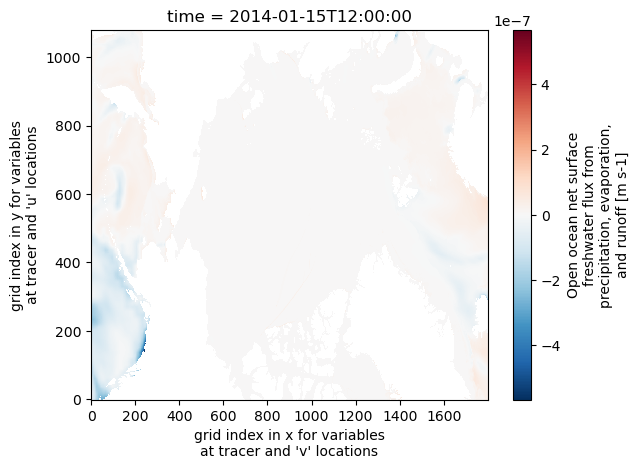

In [44]:
data["EXFempmr"].isel(time=0).plot()

## 4.2 Using Icechunk store

In [47]:
def open_icechunk_store_local(store_path: str, datafile_bucket: str, s3_creds: Optional[dict] = None):
    """
    Accesses a local icechunk repo and optionally appends Earthdata credentials to it.

    Inputs
    ------
    * repo_path (str): Path to icechunk repo.
    * s3_creds (dict, optional): Should contain values for 'accessKeyId', 'secretAccessKey', and 
        'sessionToken'.
    """
    
    config = icechunk.RepositoryConfig.default()
    config.set_virtual_chunk_container(
        icechunk.VirtualChunkContainer(
            datafile_bucket + "/",
            icechunk.s3_store(region="us-west-2"),
        )
    )
    
    # Get temporary S3 credentials for reading the actual data:
    credentials = icechunk.containers_credentials({
        datafile_bucket + "/": icechunk.s3_credentials(
            access_key_id=s3_creds["accessKeyId"],
            secret_access_key=s3_creds["secretAccessKey"],
            session_token=s3_creds["sessionToken"],
        )
    })
    
    # Open the existing repository:
    storage = icechunk.local_filesystem_storage(store_path)
    repo = icechunk.Repository.open(
        storage=storage,
        config=config,
        authorize_virtual_chunk_access=credentials,
    )

    session = repo.readonly_session(branch="main")
    return session.store

In [48]:
earthaccess.login()

In [49]:
s3_creds = earthaccess.get_s3_credentials(daac="PODAAC")
store = open_icechunk_store_local("SASSIE_ECCO_DAILY_ALL.icechunk", bucket, s3_creds)

  2026-02-20T01:18:26.943893Z  WARN icechunk::storage::object_store: The LocalFileSystem storage is not safe for concurrent commits. If more than one thread/process will attempt to commit at the same time, prefer using object stores.
    at icechunk/src/storage/object_store.rs:81



In [50]:
%%time
## Use it to open data on Earthdata:
data = xr.open_zarr(
    store,
    zarr_format=3,
    consolidated=False,
    chunks={},
)
data

CPU times: user 87.6 ms, sys: 10.2 ms, total: 97.8 ms
Wall time: 342 ms


<xarray.Dataset> Size: 216GB
Dimensions:    (time: 20, k_l: 90, j: 1080, i: 1800, k: 90, i_g: 1800,
                j_g: 1080, nb: 4, k_p1: 91, k_u: 90, nv: 2)
Coordinates: (12/23)
    XC         (j, i) float32 8MB dask.array<chunksize=(1080, 1800), meta=np.ndarray>
    XU         (j, i_g) float32 8MB dask.array<chunksize=(1080, 1800), meta=np.ndarray>
    XV         (j_g, i) float32 8MB dask.array<chunksize=(1080, 1800), meta=np.ndarray>
    YC         (j, i) float32 8MB dask.array<chunksize=(1080, 1800), meta=np.ndarray>
    Zl         (k_l) float32 360B dask.array<chunksize=(90,), meta=np.ndarray>
    Z          (k) float32 360B dask.array<chunksize=(90,), meta=np.ndarray>
    ...         ...
  * i_g        (i_g) int32 7kB 0 1 2 3 4 5 6 ... 1794 1795 1796 1797 1798 1799
  * k_l        (k_l) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
    time_bnds  (time, nv) datetime64[ns] 320B dask.array<chunksize=(1, 2), meta=np.ndarray>
    Z_bnds     (k, nv) float32 720B dask.array<chunksize=(90, 2), meta=np.ndarray>
  * j_g        (j_g) int32 4kB 0 1 2 3 4 5 6 ... 1074 1075 1076 1077 1078 1079
  * time       (time) datetime64[ns] 160B 2014-01-15T12:00:00 ... 2014-02-03T...
Dimensions without coordinates: nb, nv
Data variables: (12/50)
    ADVr_SLT   (time, k_l, j, i) float32 14GB dask.array<chunksize=(1, 15, 270, 450), meta=np.ndarray>
    ADVr_TH    (time, k_l, j, i) float32 14GB dask.array<chunksize=(1, 15, 270, 450), meta=np.ndarray>
    ADVx_TH    (time, k, j, i_g) float32 14GB dask.array<chunksize=(1, 15, 270, 450), meta=np.ndarray>
    ADVy_TH    (time, k, j_g, i) float32 14GB dask.array<chunksize=(1, 15, 270, 450), meta=np.ndarray>
    ETAN       (time, j, i) float32 156MB dask.array<chunksize=(1, 1080, 1800), meta=np.ndarray>
    EXFaqh     (time, j, i) float32 156MB dask.array<chunksize=(1, 1080, 1800), meta=np.ndarray>
    ...         ...
    SItflux    (time, j, i) float32 156MB dask.array<chunksize=(1, 1080, 1800), meta=np.ndarray>
    UVELMASS   (time, k, j, i_g) float32 14GB dask.array<chunksize=(1, 15, 270, 450), meta=np.ndarray>
    SIrsSubl   (time, j, i) float32 156MB dask.array<chunksize=(1, 1080, 1800), meta=np.ndarray>
    oceFWflx   (time, j, i) float32 156MB dask.array<chunksize=(1, 1080, 1800), meta=np.ndarray>
    oceQnet    (time, j, i) float32 156MB dask.array<chunksize=(1, 1080, 1800), meta=np.ndarray>
    oceQsw     (time, j, i) float32 156MB dask.array<chunksize=(1, 1080, 1800), meta=np.ndarray>
Attributes: (12/45)
    acknowledgement:                   This research was carried out by the J...
    author:                            Marie Zahn, Mike Wood, Ian Fenty, and ...
    cdm_data_type:                     Grid
    Conventions:                       CF-1.8, ACDD-1.3
    creator_email:                     marie.j.zahn@jpl.nasa.gov
    creator_institution:               NASA Jet Propulsion Laboratory (JPL)
    ...                                ...
    time_coverage_resolution:          P1D
    geospatial_vertical_max:           0.0
    geospatial_vertical_min:           -7000.0
    geospatial_vertical_positive:      up
    geospatial_vertical_resolution:    variable
    geospatial_vertical_units:         meter

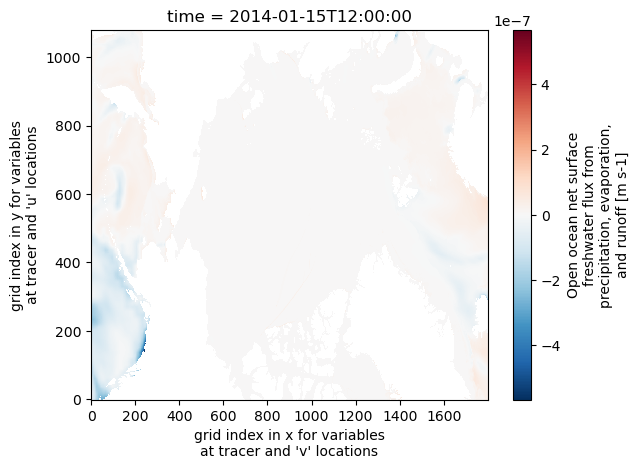

In [51]:
data["EXFempmr"].isel(time=0).plot()